In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import datetime as dt
import plotly
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from subprocess import check_output

print(check_output(["ls", "/root/userspace/final/input"]).decode("utf8"))
import os
os.chdir('/root/userspace/final/input')

#Load the Data 
filename = '4307.jp.txt'
data = pd.read_csv(filename, sep=',')
label, _, _ = filename.split(sep='.')
data['Label'] = filename
data['Date'] = pd.to_datetime(data['Date'])
print(data)

4307.jp.txt

           Date   Open   High    Low  Close   Volume  CloseAdjust        Label
0    2001-12-17  14850  14850  13800  14050  6566899        774.1  4307.jp.txt
1    2001-12-18  14000  14080  13810  13900  1358100        765.8  4307.jp.txt
2    2001-12-19  13890  14100  13420  13960   921800        769.2  4307.jp.txt
3    2001-12-20  14100  14290  13930  14230   533800        784.0  4307.jp.txt
4    2001-12-21  14300  14580  14100  14550   508000        801.7  4307.jp.txt
5    2001-12-25  14550  14550  14060  14100   140700        776.9  4307.jp.txt
6    2001-12-26  14300  14940  14200  14890   416300        820.4  4307.jp.txt
7    2001-12-27  15090  15490  15060  15320   835900        844.1  4307.jp.txt
8    2001-12-28  15500  15520  15310  15380   229200        847.4  4307.jp.txt
9    2002-01-04  15580  15620  15100  15310   168800        843.5  4307.jp.txt
10   2002-01-07  15490  16130  15390  15900   585500        876.0  4307.jp.txt
11   2002-01-08  15990  16540  15910  1

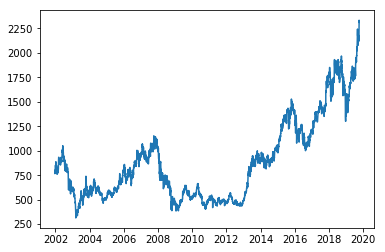

In [6]:
#Close Price adjusted
data = data.sort_values('Date')
label = data['Label'].iloc[0]
plt.plot(data['Date'], data['CloseAdjust'], label="NRI")

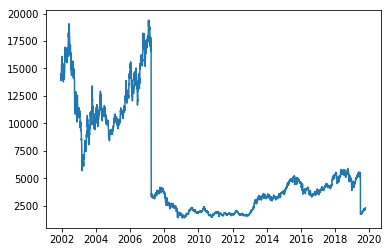

In [7]:
#Close Price not be adjusted
data = data.sort_values('Date')
label = data['Label'].iloc[0]
plt.plot(data['Date'], data['Close'], label="ETF")

In [8]:
#Create windows and normalize the data

window_len = 20

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(data["Date"][-(2*window_len+1):])[0]

#Split the training and test set
training_set, test_set = data[data['Date'] < split_date], data[data['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'Close'], 1)
test_set = test_set.drop(['Date','Label','Close'], 1)

#Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['CloseAdjust'][window_len:].values/training_set['CloseAdjust'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['CloseAdjust'][window_len:].values/test_set['CloseAdjust'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [9]:
print(test_set)

      Open  High   Low   Volume  CloseAdjust
4325  1951  1962  1934   949700       1937.0
4326  1914  1946  1899  1702300       1905.0
4327  1933  1939  1914  1135300       1933.0
4328  1920  1955  1898  1292500       1954.0
4329  1960  1985  1946  1326100       1972.0
4330  2000  2008  1952  1112100       1968.0
4331  1972  2028  1970  1456700       2017.0
4332  1991  2000  1979  1031000       1994.0
4333  2030  2034  1994  1210600       2015.0
4334  2018  2063  2009  1600700       2059.0
4335  1997  2033  1995  1773700       2020.0
4336  2059  2065  2037  1497400       2050.0
4337  2073  2109  2068  1859500       2092.0
4338  2090  2090  2040  1533800       2086.0
4339  2100  2113  2082  1248800       2113.0
4340  2110  2170  2108  2303800       2170.0
4341  2170  2201  2153  1522800       2185.0
4342  2183  2206  2179  1791400       2205.0
4343  2220  2250  2217  1385900       2242.0
4344  2249  2249  2173  1875700       2180.0
4345  2215  2222  2158  2775300       2166.0
4346  2125

In [10]:
#LSTM model definition
def build_model(inputs, output_size, neurons, activ_func="linear", dropout=0.25, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [11]:
#Train the LSTM model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 64)

# train model on data
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs=5, batch_size=1, verbose=2, shuffle=True)

Epoch 1/5
 - 128s - loss: 0.0284
Epoch 2/5
 - 124s - loss: 0.0204
Epoch 3/5
 - 124s - loss: 0.0192
Epoch 4/5
 - 124s - loss: 0.0186
Epoch 5/5
 - 124s - loss: 0.0184


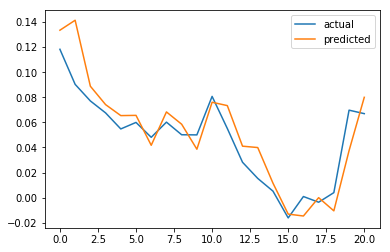

The Mean Absolute Error is: 0.013515138713542965


In [12]:
#Plot of prediction of one data point ahead
#As can be seen in the plot, one step prediction is not bad. The scale is a bit of, because the data is normalized.

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

In [13]:
print(LSTM_test_inputs)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [-1.89646335e-02 -8.15494393e-03 -1.80972079e-02  7.92460777e-01
   -1.65203924e-02]
  [-9.22603793e-03 -1.17227319e-02 -1.03412616e-02  1.95430136e-01
   -2.06504904e-03]
  ...
  [ 1.18913378e-01  1.24362895e-01  1.26680455e-01  8.86279878e-01
    1.38358286e-01]
  [ 1.37878011e-01  1.46788991e-01  1.46328852e-01  4.59302938e-01
    1.57459990e-01]
  [ 1.52742183e-01  1.46279307e-01  1.23578077e-01  9.75044751e-01
    1.25451729e-01]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 9.92685475e-03 -3.59712230e-03  7.89889415e-03 -3.33078776e-01
    1.46981627e-02]
  [ 3.13479624e-03  4.62487153e-03 -5.26592944e-04 -2.40733126e-01
    2.57217848e-02]
  ...
  [ 1.59874608e-01  1.56217883e-01  1.67456556e-01 -1.85866181e-01
    1.76902887e-01]
  [ 1.75026123e-01  1.55704008e-01  1.44286467e-01  1.01862186e-01
    1.44356955e-01]
  [ 1.57262278e-01  1.4182939

In [14]:
print(LSTM_test_outputs)

[ 0.11822406  0.09028871  0.07708226  0.06755374  0.05476673  0.05995935
  0.04809122  0.06018054  0.05012407  0.05002428  0.08069307  0.05512195
  0.02820268  0.01534036  0.00520587 -0.01612903  0.00091533 -0.00362812
  0.00401427  0.06972477  0.06694367]


In [15]:
#Reference1: https://www.kaggle.com/johanvandenheuvel/lstm-model-of-stockdata
#Reference2: https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py